In [2]:
%pip install -e ..
%load_ext autoreload
%autoreload 2

Obtaining file:///C:/Users/USER/Desktop/projects/Health%20Insurance%20Model
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for insurance (pyproject.toml): started
  Building editable for insurance (pyproject.toml): finished with status 'done'
  Created wheel for insurance: filename=insurance-0.1.0-0.editable-py3-none-any.whl size=1307 sha256=b0720bdc9fdac099214d1b5efdc56cf39f9349c782279a79d6dbf9f6367fe464
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-wheel-cache-0db4es2i\wheels\c7\86\56\d85e9c1741a69fba656


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:

import pandas as pd, numpy as np, joblib, pathlib, datetime as dt
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from insurance.data.load import load_raw
from insurance.features.engineering import prepare_data
from insurance.features.risk_score import add_normalized_risk_score
from sklearn.model_selection import train_test_split

### Building Dataset

In [8]:
def build_dataset() -> pd.DataFrame:
    df = add_normalized_risk_score(prepare_data(load_raw()))
    df["insurance_plan"] = df["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})
    return df.drop(columns=["income_level"])   # high VIF

df = build_dataset()
X = df.drop("annual_premium_amount", axis=1)
y = df["annual_premium_amount"]


In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Loading Newest XGB pipeline

In [5]:
MODEL_DIR = pathlib.Path.cwd().parent / "src" / "insurance" / "models"
xgb_path  = max(MODEL_DIR.glob("premium_XGB_*.joblib"), key=lambda p: p.stat().st_mtime)

model_xgb = joblib.load(xgb_path)
print("✔ loaded", xgb_path)

✔ loaded c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_XGB_20250527.joblib


In [11]:
print("TRAIN")
y_pred_train = model_xgb.predict(X_train)
print("Train MAE :", mean_absolute_error(y_train, y_pred_train))
print("Train R²  :", r2_score(y_train,  y_pred_train))

print("*"*30)
print("TEST")
y_pred_test = model_xgb.predict(X_test)
print("Test  MAE :", mean_absolute_error(y_test,  y_pred_test))
print("Test  R²  :", r2_score(y_test,   y_pred_test))
print("≤10 % ok  :", (np.abs((y_test - y_pred_test)/y_test) < 0.10).mean())

TRAIN
Train MAE : 737.1622924804688
Train R²  : 0.9830716252326965
******************************
TEST
Test  MAE : 760.0545654296875
Test  R²  : 0.9815726280212402
≤10 % ok  : 0.7130417375638074


#### Problem statement refreshment

1. **Achieve high accuracy**  
   - ≥ **97 %** overall predictive accuracy.  
   - For at least **95 %** of predictions, the percentage error must be **< 10 %**.

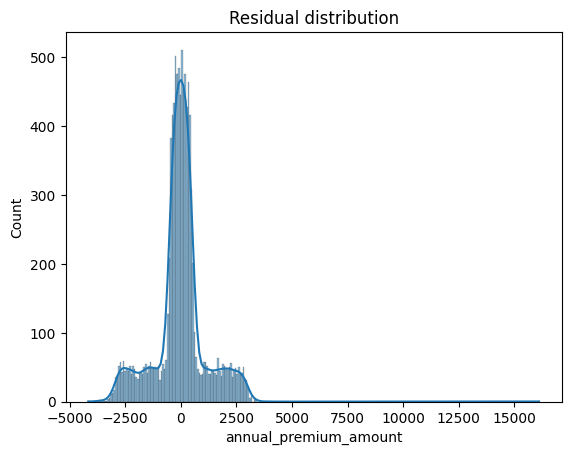

In [13]:
resid = y_test - y_pred_test
sns.histplot(resid, kde=True)
plt.title("Residual distribution")
plt.show()


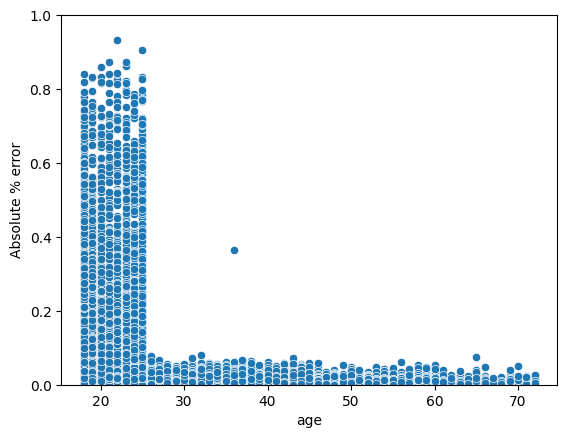

In [14]:
sns.scatterplot(x=df["age"], y=np.abs(resid)/y_test)
plt.ylim(0, 1)
plt.ylabel("Absolute % error")
plt.show()


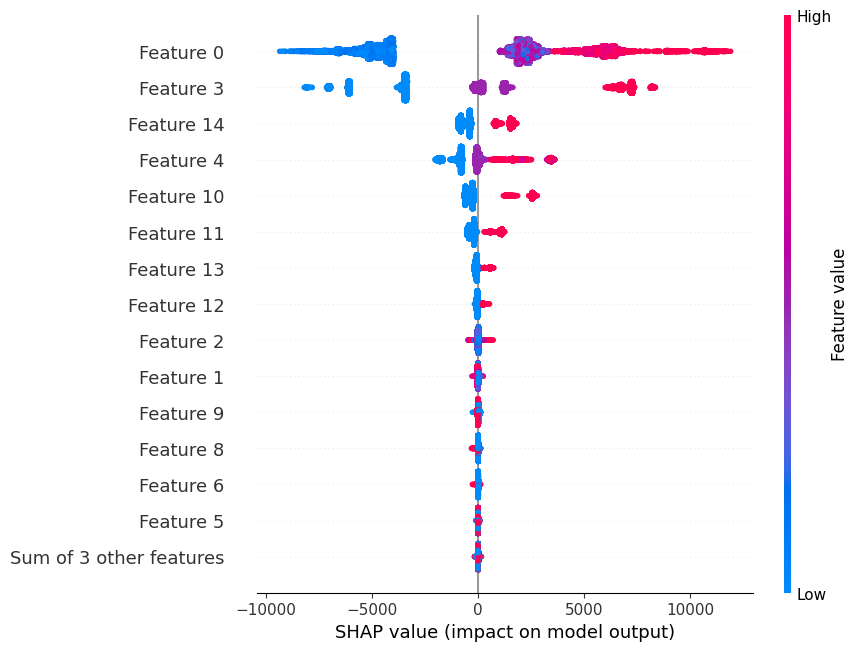

In [15]:
import shap
expl = shap.TreeExplainer(model_xgb.named_steps["model"])
X_enc = model_xgb.named_steps["prep"].transform(X)
sh_values = expl(X_enc, check_additivity=False)

shap.plots.beeswarm(sh_values, max_display=15)
